In [2]:

import duckdb
file = "C:/Users/manat/Documents/Projects/mtlBiodiversity/data/db/mtlbio.duckdb"
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

In [3]:
con = duckdb.connect(file)
df = con.execute("SELECT * from gbif_raw").df()

#df.head()

In [4]:
df_user = df.groupby(['recordedBy']).agg(obs = ('gbifID', 'nunique')).sort_values('obs', ascending= False)
top_observers = df_user.index[0:15]
df_user.head(15)


,obs
recordedBy,
Michel Goulet,8632
François Plourde - Renard frak,7542
canouquebec,7446
Serge Benoit,5746
Frederic Desmeules,4116
ornitholarocque,3980
Katherine Collin,3590
sparent66,3449
trejdil,3098


In [ ]:
cluster_size = 0.05 #in km
kms_per_radian = 6371.0088
epsilon = cluster_size / kms_per_radian



for idx, obs in enumerate(top_observers):
    if obs != 'robert_thibault':
        break
    df_obs = df.loc[df.recordedBy == obs, ['gbifID', 'decimalLatitude', 'decimalLongitude']]
    coords = np.radians(df_obs[['decimalLatitude', 'decimalLongitude']].values)
    db = DBSCAN(eps=epsilon,
                min_samples=1,
                algorithm='ball_tree',
                metric='haversine').fit(coords)
    
    labels = db.labels_
    df_obs['cluster'] = labels
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    #sns.scatterplot(df_obs, x = 'decimalLongitude', y = 'decimalLatitude', hue = 'cluster')
    #print(df_obs)   
    #plt.show() 
    

Estimated number of clusters: 433
Estimated number of noise points: 0


In [26]:
df_clusters = df_obs.groupby('cluster').nunique()
print(df_clusters)

         gbifID  decimalLatitude  decimalLongitude
cluster                                           
0          6701             2748              3542
1          1205              426               413
2            26               23                26
3             2                2                 2
4             2                2                 2
...         ...              ...               ...
428           1                1                 1
429           1                1                 1
430           1                1                 1
431           1                1                 1
432           1                1                 1

[433 rows x 3 columns]


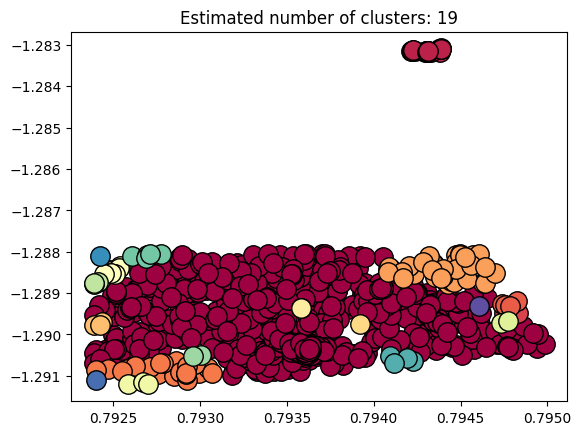

In [18]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = coords[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = coords[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [6]:
con.close()